<a href="https://colab.research.google.com/github/SLCFLAB/IBK2023/blob/main/06_DL_forecast_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: https://github.com/SLCFLAB/DL-Forecasting/tree/main

In [ ]:
!pip install neuralforecast datasetsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.4/301.4 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.4 MB/s 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast.losses.numpy import mae
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST
from datasetsforecast.long_horizon import LongHorizon

### Data 전처리

In [ ]:
data_gold = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day2/datasets/gold.csv')
data_silver = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day2/datasets/silver.csv')

In [ ]:
def standard_scaler(data):
    mean = data['y'].mean()
    std = data['y'].std()
    data['y'] = (data['y']-mean)/std
    return mean, std, data

In [ ]:
mean_gold, std_gold, data_gold = standard_scaler(data_gold)
mean_silver, std_silver, data_silver = standard_scaler(data_silver)

In [ ]:
data = pd.concat([data_gold,data_silver])
data

,ds,y,unique_id
0,0,-1.336501,gold
1,1,-1.323519,gold
2,2,-1.260577,gold
3,3,-1.291655,gold
4,4,-1.246415,gold
...,...,...,...
1285,1285,0.951773,silver
1286,1286,0.983087,silver
1287,1287,0.920697,silver
1288,1288,0.968616,silver


### **학습**

In [ ]:
horizon = 1

In [ ]:
%%capture
models_tf = [Informer(h=horizon,                    # Forecasting horizon
                      input_size=10,                # Input size
                      max_steps=2000,               # Number of training iterations
                      val_check_steps=100,          # Compute validation loss every 100 steps
                      early_stop_patience_steps=3), # Stop training if validation loss does not improve
             Autoformer(h=horizon,
                        input_size=30,
                        max_steps=1000,
                        val_check_steps=100,
                        early_stop_patience_steps=3),
             PatchTST(h=horizon,
                        input_size=30,
                        max_steps=1000,
                        val_check_steps=100,
                        early_stop_patience_steps=3),
             ]

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
tf = NeuralForecast(models=models_tf, freq='D')

data_tf = tf.cross_validation(df=data,
                               val_size=int(.1*len(data.ds.unique())),
                               test_size=int(.1*len(data.ds.unique())),
                               n_windows=None)

In [ ]:
data_tf = pd.read_csv('https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day2/datasets/gold_silver_pretrained.csv')

In [ ]:
tf_predict = data_tf[data_tf['ds']-data_tf['cutoff']==horizon]
tf_predict

,Unnamed: 0,unique_id,ds,cutoff,Informer,Autoformer,PatchTST,y
0,0,gold,1161,1160,1.086148,1.072559,1.116271,1.150495
1,1,gold,1162,1161,1.131429,1.105817,1.175186,1.153642
2,2,gold,1163,1162,1.133152,1.170764,1.169328,1.181573
3,3,gold,1164,1163,1.158979,1.144914,1.184329,1.174098
4,4,gold,1165,1164,1.145016,1.174784,1.190378,1.215010
...,...,...,...,...,...,...,...,...
253,253,silver,1285,1284,0.910531,0.980750,0.923755,0.951773
254,254,silver,1286,1285,0.915956,0.985441,0.948709,0.983087
255,255,silver,1287,1286,0.972305,1.009074,0.983380,0.920697
256,256,silver,1288,1287,0.924850,0.944526,0.931675,0.968616


In [ ]:
tf_gold = tf_predict[tf_predict['unique_id']=='gold']
tf_silver = tf_predict[tf_predict['unique_id']=='silver']

In [ ]:
tf_gold

,Unnamed: 0,unique_id,ds,cutoff,Informer,Autoformer,PatchTST,y
0,0,gold,1161,1160,1.086148,1.072559,1.116271,1.150495
1,1,gold,1162,1161,1.131429,1.105817,1.175186,1.153642
2,2,gold,1163,1162,1.133152,1.170764,1.169328,1.181573
3,3,gold,1164,1163,1.158979,1.144914,1.184329,1.174098
4,4,gold,1165,1164,1.145016,1.174784,1.190378,1.215010
...,...,...,...,...,...,...,...,...
124,124,gold,1285,1284,1.190178,1.217738,1.199172,1.207929
125,125,gold,1286,1285,1.186163,1.179539,1.200946,1.216191
126,126,gold,1287,1286,1.207499,1.189658,1.208708,1.196128
127,127,gold,1288,1287,1.190244,1.166427,1.199881,1.228779


### **결과 분석**

In [ ]:
tf_gold[['Informer','Autoformer','PatchTST','y']] = tf_gold[['Informer','Autoformer','PatchTST','y']]*std_gold + mean_gold
tf_silver[['Informer','Autoformer','PatchTST','y']] = tf_silver[['Informer','Autoformer','PatchTST','y']]*std_silver + mean_silver

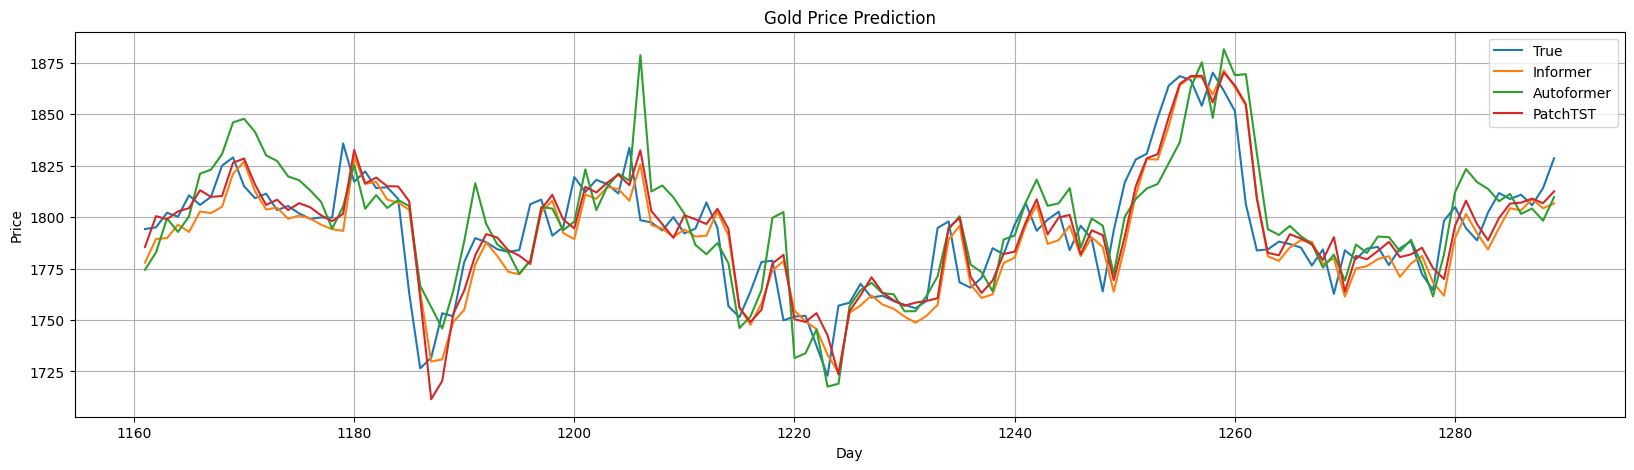

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(tf_gold['ds'], tf_gold['y'], label='True')
plt.plot(tf_gold['ds'], tf_gold['Informer'], label='Informer')
plt.plot(tf_gold['ds'], tf_gold['Autoformer'], label='Autoformer')
plt.plot(tf_gold['ds'], tf_gold['PatchTST'], label='PatchTST')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Gold Price Prediction')
plt.grid()
plt.legend()
plt.savefig('gold_tf_5step.png')
plt.show()

In [ ]:
mae_informer = mae(tf_gold['y'], tf_gold['Informer'])
mae_autoformer = mae(tf_gold['y'], tf_gold['Autoformer'])
mae_patchtst = mae(tf_gold['y'], tf_gold['PatchTST'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')

Informer: 11.837
Autoformer: 14.875
PatchTST: 11.125


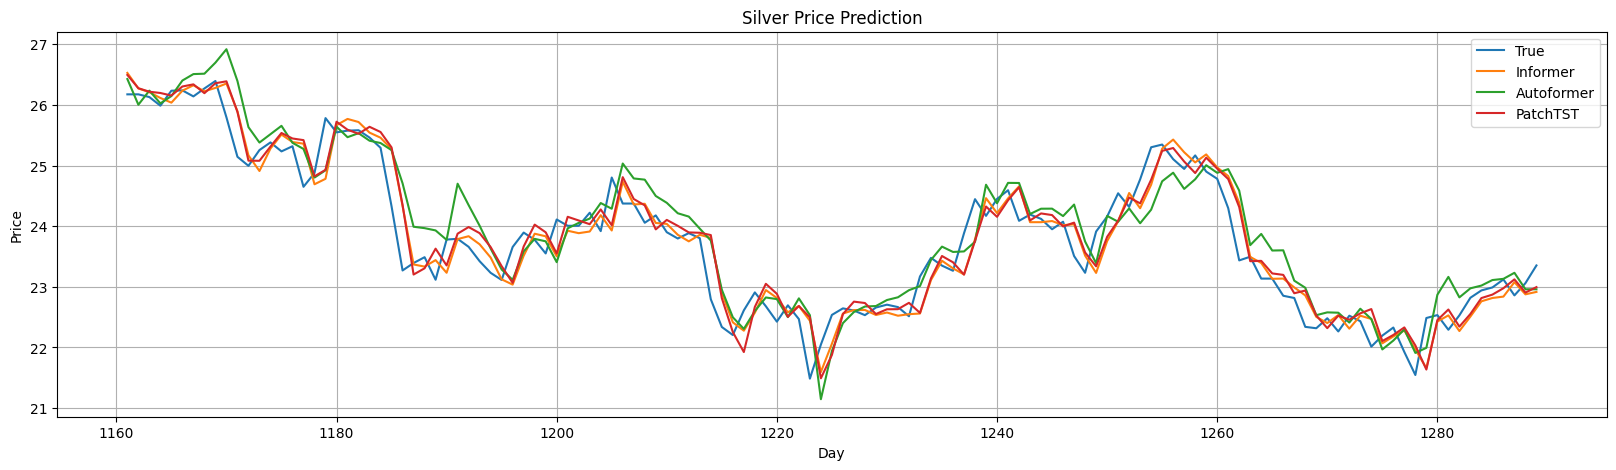

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(tf_silver['ds'], tf_silver['y'], label='True')
plt.plot(tf_silver['ds'], tf_silver['Informer'], label='Informer')
plt.plot(tf_silver['ds'], tf_silver['Autoformer'], label='Autoformer')
plt.plot(tf_silver['ds'], tf_silver['PatchTST'], label='PatchTST')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Silver Price Prediction')
plt.grid()
plt.legend()
plt.savefig('silver_tf_5step.png')
plt.show()

In [ ]:
mae_informer = mae(tf_silver['y'], tf_silver['Informer'])
mae_autoformer = mae(tf_silver['y'], tf_silver['Autoformer'])
mae_patchtst = mae(tf_silver['y'], tf_silver['PatchTST'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')

Informer: 0.294
Autoformer: 0.375
PatchTST: 0.306


### **AirPassengers Data**
Reference: https://github.com/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started.ipynb

In [ ]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


<Axes: >

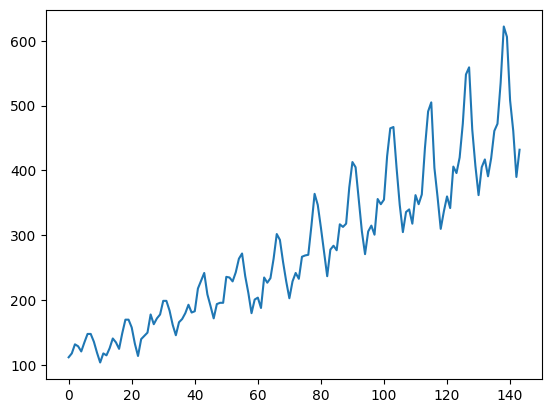

In [ ]:
Y_df['y'].plot()

In [ ]:
%%capture
horizon = 12
models = [Informer(h=horizon,                 # Forecasting horizon
                input_size=2*horizon,           # Input size
                max_steps=100), # Stop training if validation loss does not improve
          Autoformer(h=horizon,
                input_size=2*horizon,
                max_steps=100),
          PatchTST(h=horizon,
                input_size=2*horizon,
                max_steps=100),
         ]

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
Y_hat_df = nf.predict()
Y_hat_df

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,ds,Informer,Autoformer,PatchTST
unique_id,,,,
1.0,1961-01-31,6.968252,516.759521,453.290863
1.0,1961-02-28,7.337731,510.523376,444.806671
1.0,1961-03-31,7.064684,519.980530,484.817810
1.0,1961-04-30,7.339235,546.039368,508.880890
1.0,1961-05-31,7.334515,574.706177,534.994629
1.0,1961-06-30,7.226240,620.174377,618.705383
1.0,1961-07-31,7.337259,665.613037,698.576050
1.0,1961-08-31,7.349066,658.676270,678.120544
1.0,1961-09-30,7.046875,596.324280,584.509888


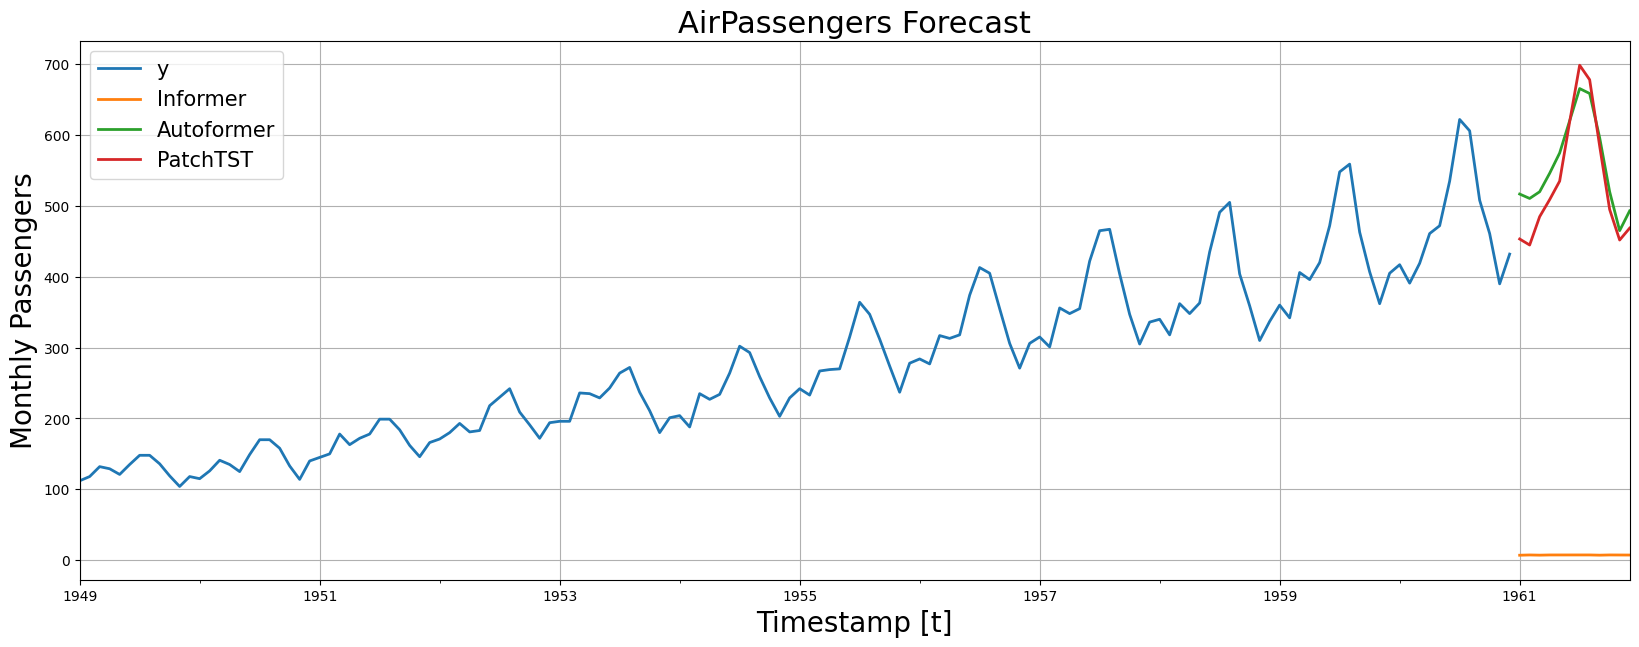

In [ ]:
Y_hat_df = Y_hat_df.reset_index()
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'Informer', 'Autoformer', 'PatchTST']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()